# Click-Through Rate Prediction: Predict whether a mobile ad will be clicked
https://www.kaggle.com/c/avazu-ctr-prediction

In [33]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from collections import namedtuple
import datetime

## Data Exploration

In [34]:
df = pd.read_csv('../data/filtered_train.csv')
pd.set_option('display.max_columns',None)
df.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33
3,791624,1.844219e+18,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23
4,491263,1.236016e+19,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33


In [35]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  float64
 1   click             404290 non-null  int64  
 2   hour              404290 non-null  int64  
 3   C1                404290 non-null  int64  
 4   banner_pos        404290 non-null  int64  
 5   site_id           404290 non-null  object 
 6   site_domain       404290 non-null  object 
 7   site_category     404290 non-null  object 
 8   app_id            404290 non-null  object 
 9   app_domain        404290 non-null  object 
 10  app_category      404290 non-null  object 
 11  device_id         404290 non-null  object 
 12  device_ip         404290 non-null  object 
 13  device_model      404290 non-null  object 
 14  device_type       404290 non-null  int64  
 15  device_conn_type  404290 non-null  int64  
 16  C14               40

In [37]:
df['click'].value_counts()

0    335635
1     68655
Name: click, dtype: int64

In [38]:
df.nunique()

id                  402586
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2225
site_domain           2188
site_category           22
app_id                2241
app_domain             143
app_category            27
device_id            64742
device_ip           261706
device_model          4380
device_type              4
device_conn_type         4
C14                   2088
C15                      8
C16                      9
C17                    411
C18                      4
C19                     65
C20                    161
C21                     60
dtype: int64

Based on explorative data analysis, hour of the day is be importance

In [39]:
df['hour_of_day'] = df['hour'].astype(str).str.slice(6, 8).astype(int) #hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
df = df.drop('id', axis = 1)
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157,1
1,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79,3
2,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33,3
3,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23,4
4,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33,3


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   click             404290 non-null  int64 
 1   hour              404290 non-null  int64 
 2   C1                404290 non-null  int64 
 3   banner_pos        404290 non-null  int64 
 4   site_id           404290 non-null  object
 5   site_domain       404290 non-null  object
 6   site_category     404290 non-null  object
 7   app_id            404290 non-null  object
 8   app_domain        404290 non-null  object
 9   app_category      404290 non-null  object
 10  device_id         404290 non-null  object
 11  device_ip         404290 non-null  object
 12  device_model      404290 non-null  object
 13  device_type       404290 non-null  int64 
 14  device_conn_type  404290 non-null  int64 
 15  C14               404290 non-null  int64 
 16  C15               404290 non-null  int

## Feature Processing

In [41]:
df.nunique().sort_values(ascending=False)

device_ip           261706
device_id            64742
device_model          4380
app_id                2241
site_id               2225
site_domain           2188
C14                   2088
C17                    411
hour                   240
C20                    161
app_domain             143
C19                     65
C21                     60
app_category            27
hour_of_day             24
site_category           22
C16                      9
C15                      8
banner_pos               7
C1                       7
device_conn_type         4
device_type              4
C18                      4
click                    2
dtype: int64

In [42]:
df = df.drop(columns=(['device_ip','device_id']))

In [43]:
obj_features = list(df.select_dtypes(['object']).columns)
int_features = list(df.select_dtypes(['int64']).columns)
int_features.remove('click')

df[obj_features] = df[obj_features].fillna('-1', )
df[int_features] = df[int_features].fillna(0, )

for feat in obj_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [44]:
sparse_features = df.loc[:, df.nunique() <= 100].columns.tolist()
sparse_features.remove('click')

In [45]:
for feat in sparse_features:
  df_temp = pd.get_dummies(df[feat], prefix=[feat])
  df = df.drop(feat, axis=1)
  df = pd.concat([df, df_temp], axis=1)
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23
0,0,14102101,1939,1096,2060,63,2331,20352,2333,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [46]:
dense_features = [feat for feat, feat_num in df.nunique().iteritems() if feat_num > 100]
dense_features

['hour',
 'site_id',
 'site_domain',
 'app_id',
 'app_domain',
 'device_model',
 'C14',
 'C17',
 'C20']

In [47]:
embedding_dict = [{'feat': feat, 'feat_num': df[feat].nunique(), 'embed_dim': 128 if df[feat].nunique() < 256 else 256} for feat in dense_features]
embedding_dict

[{'feat': 'hour', 'feat_num': 240, 'embed_dim': 128},
 {'feat': 'site_id', 'feat_num': 2225, 'embed_dim': 256},
 {'feat': 'site_domain', 'feat_num': 2188, 'embed_dim': 256},
 {'feat': 'app_id', 'feat_num': 2241, 'embed_dim': 256},
 {'feat': 'app_domain', 'feat_num': 143, 'embed_dim': 128},
 {'feat': 'device_model', 'feat_num': 4380, 'embed_dim': 256},
 {'feat': 'C14', 'feat_num': 2088, 'embed_dim': 256},
 {'feat': 'C17', 'feat_num': 411, 'embed_dim': 256},
 {'feat': 'C20', 'feat_num': 161, 'embed_dim': 128}]

In [48]:
for feat in dense_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [49]:
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23
0,0,1,1939,1096,2060,63,2331,564,144,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [50]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [51]:
device = torch.device("mps")

In [52]:
device

device(type='mps')

## Pipeline the data

In [55]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train_deep, X_test_deep = train.iloc[:, 1:10], test.iloc[:, 1:10]
X_train_wide, X_test_wide = train.iloc[:, 13:], test.iloc[:, 13:]
Y_train, Y_test = train['click'], test['click']

In [54]:
# Building the output dictionary
wd_dataset = dict()
train_dataset = namedtuple('train_dataset', 'wide, deep, label')
test_dataset  = namedtuple('test_dataset' , 'wide, deep, label')
wd_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, Y_train)
wd_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, Y_test)
wd_dataset['embedding_dict'] = embedding_dict

In [56]:
wd_dataset['train_dataset']

train_dataset(wide=        ['C1']_1007  ['C1']_1008  ['C1']_1010  ['C1']_1012  ['banner_pos']_0  \
352886            0            0            0            0                 1   
134949            0            0            0            0                 1   
168419            0            0            0            0                 1   
402543            0            0            0            0                 1   
13551             0            0            0            0                 0   
...             ...          ...          ...          ...               ...   
259178            0            0            0            0                 1   
365838            0            0            0            0                 0   
131932            0            0            0            0                 1   
146867            0            0            0            0                 0   
121958            0            0            0            0                 0   

        ['banner_pos

In [60]:
class WideDeepDataset(Dataset):
    """Helper to facilitate loading the data to the pytorch models.

    Parameters:
    --------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = torch.tensor(data.wide.values.astype(np.float32))
        self.X_deep =  torch.tensor(data.deep.values.astype(np.float32))
        self.Y =  torch.tensor(data.label.values.astype(np.float32))
        self.Y = self.Y.squeeze().unsqueeze(1)

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)

In [61]:
dl_train_dataset = WideDeepDataset(wd_dataset['train_dataset'])
dl_test_dataset = WideDeepDataset(wd_dataset['test_dataset'])

In [62]:
dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size = 32)
dl_val = DataLoader(dl_test_dataset, shuffle=True, batch_size = 32)

In [63]:
# test for traning dara
for (X_wide, X_deep, label) in iter(dl_train):
    print(X_wide.shape, X_deep.shape, label.shape)
    break

torch.Size([32, 238]) torch.Size([32, 9]) torch.Size([32, 1])


## Model building

In [77]:
class Dnn(nn.Module):
    """
    Dnn part
    """
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout: 失活率
        """
        super(Dnn, self).__init__()
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        
        x = self.dropout(x)
        return x

In [78]:
class CrossNetwork(nn.Module):
    """
    Cross Network
    """
    def __init__(self, layer_num, input_dim):
        super(CrossNetwork, self).__init__()
        self.layer_num = layer_num
        
        # have to initialize manually
        self.cross_weights = nn.ParameterList([
            nn.Parameter(torch.rand(input_dim, 1))
            for i in range(self.layer_num)
        ])
        self.cross_bias = nn.ParameterList([
            nn.Parameter(torch.rand(input_dim, 1))
            for i in range(self.layer_num)
        ])
    
    def forward(self, x):
        # x dim: (number of samples, embedding dim + dense dim)
        # cross calculation should be performed for each sample -> instead of treating samples as vectors, treat each sample as a matrix since vectors would stack together and there's no way to make a difference between samples.
        x_0 = torch.unsqueeze(x, dim=2) # x_0 dim: (number of samples, embedding dim + dense dim, 1)
        x = x_0.clone()
        xT = x_0.clone().permute((0, 2, 1))     # xT dim: (number of samples, 1, embedding dim + dense dim) -> (1, embedding dim + dense dim) is like a marix and embedding dim + dense dim could be per sample 
        for i in range(self.layer_num):
            '''
            1. torch.bmm(x_0, xT): 
                Per sample, (embedding dim + dense dim, 1)·(1, embedding dim + dense dim) = (embedding dim + dense dim, embedding dim + dense dim). 
                All samples: (number of samples, embedding dim + dense dim, embedding dim + dense dim)
                w.o. broardcast mechanism
            2. dim for self.cross_weights[i]: (embedding dim + dense dim, 1)
            3. torch.matmul():
                has broardcast mechanism
                after torch.matmul(): dim: (number of samples, embedding dim + dense dim, 1)
            '''
            x = torch.matmul(torch.bmm(x_0, xT), self.cross_weights[i]) + self.cross_bias[i] + x 
            # for next layer 
            xT = x.clone().permute((0, 2, 1))  
            
        # x dim: (number of samples, embedding dim + dense dim)
        x = torch.squeeze(x)  
        # output: need to be the same with input dim: (number of samples, embedding dim + dense dim)
        return x

In [84]:
class DeepCross(nn.Module):
    def __init__(self, wide_dim, embedding_dict, hidden_units, cross_layer):
        super(DeepCross, self).__init__()
        self.wide_dim = wide_dim
        self.deep_dim = 0
        self.hidden_layers = hidden_units

        # For each deep feature, create an embedding layer to convert them to embeddings
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(embedding_dict)
        })
        for feat in embedding_dict:
            self.deep_dim += int(feat['embed_dim'])
        
        # A series of hidden layers that take the embeddings as input
        hidden_units.insert(0, self.deep_dim + self.wide_dim)
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        self.dnn_network = Dnn(hidden_units)
        self.cross_network = CrossNetwork(cross_layer, hidden_units[0])  
        self.fc= nn.Linear(hidden_units[-1]+hidden_units[0], 1)

    def forward(self, X_w, X_d):
        X_d = X_d.long() # embedding inputs need integer tensors
        embeddings = [self.embed_layers['embed_' + str(i)](X_d[:, i]) for i in range(X_d.shape[1])]
        embeddings_cat = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
        x = torch.cat([X_w, embeddings_cat], axis=-1)
        
        # cross Network
        cross_out = self.cross_network(x)
        # dnn
        deep_out = self.dnn_network(x)
        # concatenate
        total_x = torch.cat([cross_out, deep_out], axis=-1)
        outputs = F.sigmoid(self.fc(total_x))
        return outputs  

In [85]:
hidden_units = [512, 256, 128]

model = DeepCross(wd_dataset['train_dataset'].wide.shape[1], wd_dataset['embedding_dict'], hidden_units, len(hidden_units))
model

DeepCross(
  (embed_layers): ModuleDict(
    (embed_0): Embedding(240, 128)
    (embed_1): Embedding(2225, 256)
    (embed_2): Embedding(2188, 256)
    (embed_3): Embedding(2241, 256)
    (embed_4): Embedding(143, 128)
    (embed_5): Embedding(4380, 256)
    (embed_6): Embedding(2088, 256)
    (embed_7): Embedding(411, 256)
    (embed_8): Embedding(161, 128)
  )
  (bn_1): BatchNorm1d(2158, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dnn_network): Dnn(
    (dnn_network): ModuleList(
      (0): Linear(in_features=2158, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (cross_network): CrossNetwork(
    (cross_weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 2158x1]
        (1): Parameter containing: [torch.float32 of size 2158x1]
        (2): Parameter containing: [torch

In [86]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model.to(device)
# Throw an error when only one class present in y_true, thus need to do error processing
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)
metric_func = auc
metric_name = 'auc'

In [87]:
dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])

In [89]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
n_epoches = 10
print('Start training......')
starttime = datetime.datetime.now()
print('=='* 30)

for epoch in tqdm(range(1, n_epoches + 1)):
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (X_wide, X_deep, label) in enumerate(dl_train, 1):
        X_wide = X_wide.to(device)
        X_deep = X_deep.to(device)
        label = label.to(device)
        y_pred = model(X_wide, X_deep)
        y_pred = y_pred.cpu()
        label = label.cpu()
        loss = loss_fn(y_pred, label)
        try:          
            metric = metric_func(y_pred, label)
        except ValueError:
            pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

        if step % 5000 == 0:
            print(f"Step {step} of Epoch {epoch}:\n\t Average training loss: {loss_sum/step}.\n\t Average auc score: {metric_sum/step}")
            
    
    # evaluate
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (X_wide, X_deep, label) in enumerate(dl_val, 1):
        with torch.no_grad():
            X_wide = X_wide.to(device)
            X_deep = X_deep.to(device)
            label = label.to(device)
            y_pred = model(X_wide, X_deep)
            y_pred = y_pred.cpu()
            label = label.cpu()
            val_loss = loss_fn(y_pred, label)
            try:          
                val_metric = metric_func(y_pred, label)
            except ValueError:
                pass
            
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch - 1] = info
    
    print(f"Epoch {epoch} of {n_epoches}:\n\t  Average testing loss: {val_loss_sum/val_step}.\n\t Average auc score: {val_metric_sum/val_step}")
    endtime = datetime.datetime.now()
    print('Training time fo this epoch is {}'.format(endtime - starttime))
    print('=='* 20)


print('Finished Training!')

Start training......


  0%|          | 0/10 [11:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(dfhistory)

,epoch,loss,auc,val_loss,val_auc


## Model Evaluation

/Users/wangyufei/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wangyufei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


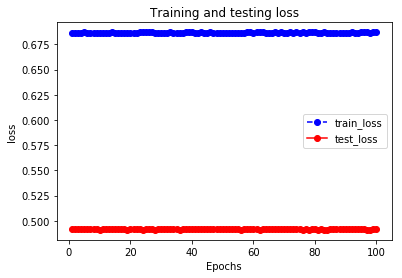

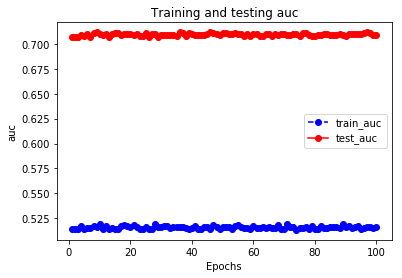

In [ ]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and testing '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'test_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")
plot_metric(dfhistory, "auc")

## Prediction

In [ ]:
y_pred_probs = model(torch.tensor(wd_dataset['test_dataset'].wide.values.astype(np.float32)).to(device), torch.tensor(wd_dataset['test_dataset'].deep.values.astype(np.float32)).to(device))
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [ ]:
y_pred.data

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [69]:
torch.save(model_2, 'W&D.pkl')

PicklingError: Can't pickle <class '__main__.WideDeep_2'>: it's not the same object as __main__.WideDeep_2